<a href="https://colab.research.google.com/github/AryaPratamaPutra-10/Analys_Data_Lele/blob/main/Analisis%20data%20lele%20part%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import get_ipython
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# atau algoritma lain seperti RandomForestRegressor, SVR, dll.
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Add, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import joblib

In [2]:
import pandas as pd

# Membaca data keseluruhan

# Skenario 1
Lele_data_url = "https://github.com/AryaPratamaPutra-10/Analys_Data_Lele/raw/75a3f74df5b05158dbf856cca04b977a20d67a47/Data_Lele_1.csv"

# Baca data CSV dengan penanganan error, tanpa parsing dates atau index_col
df = pd.read_csv(Lele_data_url, sep=';')  # Diasumsikan ';' sebagai delimiter

# Print nama kolom untuk verifikasi
print(df.columns)

# Ubah 'Tahun' menjadi bilangan bulat yang mewakili tahun
df['Tahun'] = pd.to_numeric(df['Tahun'], errors='coerce').astype('Int64')

# Sekarang, tetapkan 'Tahun' sebagai indeks
df = df.set_index('Tahun')

print('Dataset : \n', df.head())
print('Dataset : \n', df.tail())
print('\n')

# Menghitung jumlah tahun dalam dataset
days_count = len(df.index)
print("Jumlah Harga Lele dalam dataset:", days_count)

Index(['Id', 'Provinsi', 'Kabupaten/Kota', 'Jenis Ikan', 'Tahun',
       'Volume Produksi', 'Nilai Produksi', 'Harga Lele'],
      dtype='object')
Dataset : 
        Id    Provinsi Kabupaten/Kota Jenis Ikan  Volume Produksi  \
Tahun                                                              
2019  NaN  JAWA BARAT        BANDUNG       LELE          5372785   
2019  NaN  JAWA BARAT  BANDUNG BARAT       LELE          1328082   
2019  NaN  JAWA BARAT         BEKASI       LELE          2019121   
2019  NaN  JAWA BARAT          BOGOR       LELE         89814340   
2019  NaN  JAWA BARAT         CIAMIS       LELE         18162827   

       Nilai Produksi  Harga Lele  
Tahun                              
2019      85964560000     16000.0  
2019      19921230000     15000.0  
2019      34325057000     17000.0  
2019    1526843780000     17000.0  
2019     236116751000     13000.0  
Dataset : 
        Id    Provinsi Kabupaten/Kota Jenis Ikan  Volume Produksi  \
Tahun                           

In [5]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
encoder_provinsi = LabelEncoder()
encoder_kabupaten = LabelEncoder()

# Melakukan fit_transform pada kolom 'Provinsi' dan 'Kabupaten/Kota'
df['Provinsi_Encoded'] = encoder_provinsi.fit_transform(df['Provinsi'])
df['Kabupaten_Encoded'] = encoder_kabupaten.fit_transform(df['Kabupaten/Kota'])

# Menghapus kolom asli jika diinginkan
# df = df.drop(['Provinsi', 'Kabupaten/Kota'], axis=1)


 Correlation Matrix 



<Axes: >

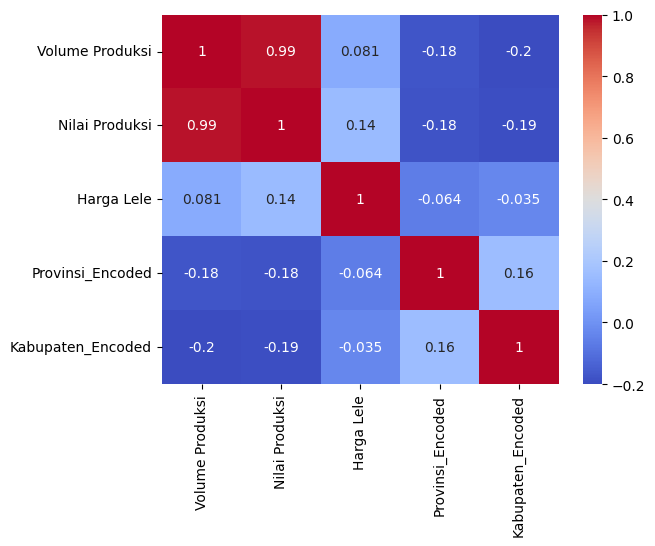

In [8]:
print("\n Correlation Matrix \n")

matrix = df.drop(columns=['Id', 'Provinsi', 'Kabupaten/Kota', 'Jenis Ikan']).corr()
# matrix = df.corr()
# Plotting correlation matrix
sns.heatmap(matrix, cmap="coolwarm", annot=True)



In [13]:
# Membagi data menjadi training, validation, dan testing sets

# Scenario 1 - 70:15:15
train = df.loc[df.index.isin(range(2019, 2020))] # Include 2019 and 2020
validation = df.loc[df.index.isin([2021, 2022])]  # Include 2021 and 2022
test = df.loc[df.index == 2023]  # Include 2023

# Displaying the number of records in each set
print(f'Training set: {train.shape[0]} records')
print(f'Validation set: {validation.shape[0]} records')
print(f'Test set: {test.shape[0]} records')

# Selecting features and target
features = ['Volume Produksi', 'Nilai Produksi', "Provinsi", "Kabupaten/Kota"] # Faktor yang mempengaruhi harga lele
X_train = train[features]
y_train = train['Harga Lele']
X_val = validation[features]
y_val = validation['Harga Lele']
X_test = test[features]
y_test = test['Harga Lele']


Training set: 100 records
Validation set: 200 records
Test set: 100 records


In [14]:
from sklearn.model_selection import train_test_split

# Selecting features and target
features = ['Volume Produksi', 'Nilai Produksi', "Provinsi", "Kabupaten/Kota"] # Faktor yang mempengaruhi harga lele
X = df[features]
y = df['Harga Lele']

# Splitting data into 70:15:15 ratio
# First split into train (70%) and the rest (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then split the rest (30%) into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Displaying the number of records in each set
print(f'Training set: {X_train.shape[0]} records')
print(f'Validation set: {X_val.shape[0]} records')
print(f'Test set: {X_test.shape[0]} records')

Training set: 350 records
Validation set: 75 records
Test set: 75 records


In [15]:
# Normalisasi data Fitur dan target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape y_train, y_val, y_test to (n_samples, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_val_reshaped = y_val.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Fit and transform on training set, transform on validation and test sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
y_val_scaled = scaler_y.transform(y_val_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

# Fungsi untuk membentuk data menjadi sequence
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Misalnya, gunakan 10 hari sebelumnya untuk memprediksi hari berikutnya
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Save the scalers
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


ValueError: could not convert string to float: 'JAWA BARAT'

In [18]:
!pip install scikit-learn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import joblib  # Pastikan Anda telah mengimpor joblib

# Normalisasi data Fitur dan target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape y_train, y_val, y_test to (n_samples, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_val_reshaped = y_val.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# --- Mengubah data kategorikal menjadi string ---
# Membuat salinan DataFrame untuk menghindari modifikasi data asli
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()

# Mengubah kolom kategorikal menjadi tipe data string
for col in ["Provinsi", "Kabupaten/Kota"]:
    X_train_encoded[col] = X_train_encoded[col].astype(str)
    X_val_encoded[col] = X_val_encoded[col].astype(str)
    X_test_encoded[col] = X_test_encoded[col].astype(str)

# --- Menggunakan OrdinalEncoder untuk mengubah string menjadi numerik ---
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)  # Inisialisasi OrdinalEncoder dengan handle_unknown dan unknown_value

# Fit dan transform pada data training, lalu transform pada data validation dan test
X_train_encoded[["Provinsi", "Kabupaten/Kota"]] = encoder.fit_transform(X_train_encoded[["Provinsi", "Kabupaten/Kota"]])
X_val_encoded[["Provinsi", "Kabupaten/Kota"]] = encoder.transform(X_val_encoded[["Provinsi", "Kabupaten/Kota"]])
X_test_encoded[["Provinsi", "Kabupaten/Kota"]] = encoder.transform(X_test_encoded[["Provinsi", "Kabupaten/Kota"]])

# --- Scaling data numerik ---
# Fit and transform on training set, transform on validation and test sets
X_train_scaled = scaler_X.fit_transform(X_train_encoded)
X_val_scaled = scaler_X.transform(X_val_encoded)
X_test_scaled = scaler_X.transform(X_test_encoded)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
y_val_scaled = scaler_y.transform(y_val_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

# --- Fungsi untuk membentuk data menjadi sequence (tidak berubah) ---
# Fungsi untuk membentuk data menjadi sequence
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Misalnya, gunakan 10 hari sebelumnya untuk memprediksi hari berikutnya
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# --- Menyimpan scaler (tidak berubah) ---
# ... (kode untuk menyimpan scaler tetap sama)
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


['scaler_y.pkl']

In [19]:
# Verifikasi bentuk data
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_val_seq:", X_val_seq.shape)
print("Shape of y_val_seq:", y_val_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)


Shape of X_train_seq: (340, 10, 4)
Shape of y_train_seq: (340,)
Shape of X_val_seq: (65, 10, 4)
Shape of y_val_seq: (65,)
Shape of X_test_seq: (65, 10, 4)
Shape of y_test_seq: (65,)


# **Regular LSTM model build and training**

In [26]:
# Membangun model LSTM biasa
def build_lstm_model(input_shape, units=512, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Membangun model LSTM
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm = build_lstm_model(input_shape)

# Displaying model summary
model_lstm.summary()

history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM
y_pred_lstm = model_lstm.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

#def r2_score(y_true, y_pred):
   # mean_y_true = sum(y_true) / len(y_true)
    #ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    #ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    #r2 = 1 - (ss_res / ss_tot)
    #return r2

mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print(" \n ===================================================== \n")
#print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM: {rmse_lstm}')
print(" \n ===================================================== \n")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 10, 512)             │       1,058,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 10, 512)             │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,257,729 (20.06 MB)

 Trainable params: 5,257,729 (20.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 - 13s - 1s/step - loss: 0.0530 - val_loss: 0.0261
Epoch 2/50
11/11 - 7s - 674ms/step - loss: 0.0330 - val_loss: 0.0222
Epoch 3/50
11/11 - 6s - 572ms/step - loss: 0.0245 - val_loss: 0.0214
Epoch 4/50
11/11 - 12s - 1s/step - loss: 0.0214 - val_loss: 0.0217
Epoch 5/50
11/11 - 7s - 596ms/step - loss: 0.0218 - val_loss: 0.0230
Epoch 6/50
11/11 - 10s - 887ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 7/50
11/11 - 8s - 689ms/step - loss: 0.0221 - val_loss: 0.0207
Epoch 8/50
11/11 - 9s - 809ms/step - loss: 0.0214 - val_loss: 0.0205
Epoch 9/50
11/11 - 10s - 917ms/step - loss: 0.0222 - val_loss: 0.0209
Epoch 10/50
11/11 - 11s - 999ms/step - loss: 0.0215 - val_loss: 0.0218
Epoch 11/50
11/11 - 11s - 1s/step - loss: 0.0214 - val_loss: 0.0208
Epoch 12/50
11/11 - 9s - 783ms/step - loss: 0.0211 - val_loss: 0.0208
Epoch 13/50
11/11 - 10s - 936ms/step - loss: 0.0211 - val_loss: 0.0219
Epoch 14/50
11/11 - 10s - 922ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 15/50
11/11 - 12s - 1s/s

In [27]:
def build_lstm_attention_model(input_shape, lstm_units=32, learning_rate=0.0001):
    inputs = Input(shape=input_shape)

    # Adding multiple LSTM layers sequentially
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])
    context_vector = Add()([lstm_out, attention])

    # Global average pooling to reduce the dimensionality
    context_vector = GlobalAveragePooling1D()(context_vector)

    # Output Layer
    outputs = Dense(1)(context_vector)

    # Model compilation
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Membangun model LSTM dengan Attention Mechanism
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm_attention = build_lstm_attention_model(input_shape)

# Displaying model summary
model_lstm_attention.summary()

history_lstm_attention = model_lstm_attention.fit(X_train_seq, y_train_seq, epochs=100, batch_size=8 ,verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM dengan Attention Mechanism
y_pred_lstm_attention = model_lstm_attention.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm_attention = mean_squared_error(y_test_seq, y_pred_lstm_attention)
mae_lstm_attention = mean_absolute_error(y_test_seq, y_pred_lstm_attention)
rmse_lstm_attention = root_mean_squared_error(y_test_seq, y_pred_lstm_attention)
r2_lstm_attention = r2_score(y_test_seq, y_pred_lstm_attention)

print(" \n ===================================================== \n")
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')
print(" \n ===================================================== \n")


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 10, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ (None, 10, 32)         │          4,736 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ (None, 10, 32)         │          8,320 │ lstm_21[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ (None, 10, 32)         │          8,320 │ lstm_22[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 10, 32)         │              0 │ lstm_23[0][0],         │
│                           │                        │                │ lstm_23[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 32)         │              0 │ lstm_23[0][0],         │
│                           │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 32)             │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             33 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,409 (83.63 KB)

 Trainable params: 21,409 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
43/43 - 6s - 135ms/step - loss: 0.1022 - val_loss: 0.0509
Epoch 2/100
43/43 - 1s - 17ms/step - loss: 0.0384 - val_loss: 0.0229
Epoch 3/100
43/43 - 1s - 15ms/step - loss: 0.0238 - val_loss: 0.0228
Epoch 4/100
43/43 - 1s - 14ms/step - loss: 0.0232 - val_loss: 0.0228
Epoch 5/100
43/43 - 1s - 15ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 6/100
43/43 - 1s - 17ms/step - loss: 0.0230 - val_loss: 0.0227
Epoch 7/100
43/43 - 1s - 22ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 8/100
43/43 - 1s - 30ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 9/100
43/43 - 1s - 23ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 10/100
43/43 - 1s - 14ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 11/100
43/43 - 1s - 15ms/step - loss: 0.0224 - val_loss: 0.0218
Epoch 12/100
43/43 - 1s - 15ms/step - loss: 0.0222 - val_loss: 0.0221
Epoch 13/100
43/43 - 1s - 31ms/step - loss: 0.0222 - val_loss: 0.0217
Epoch 14/100
43/43 - 1s - 29ms/step - loss: 0.0222 - val_loss: 0.0213
Epoch 15/100
43/43 - 1s - 27

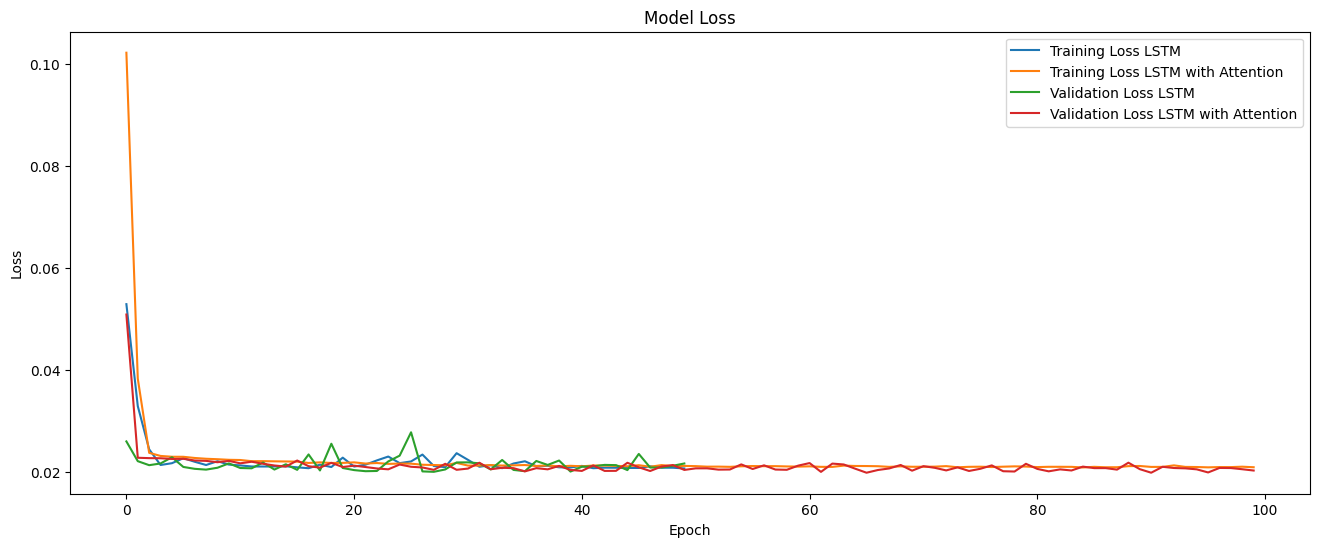

R-squared LSTM: [-0.08422256]
MSE LSTM: [0.02881847]
MAE LSTM: [0.14070292]
RMSE LSTM : [0.16976005]
R-squared LSTM with Attention: [-0.00648665]
MSE LSTM with Attention: [0.02675227]
MAE LSTM with Attention: [0.13584703]
RMSE LSTM with Attention: [0.1635612]


In [28]:
# Plot hasil pelatihan
plt.figure(figsize=(16, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm_attention.history['loss'], label='Training Loss LSTM with Attention')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
plt.plot(history_lstm_attention.history['val_loss'], label='Validation Loss LSTM with Attention')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan hasil evaluasi
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM : {rmse_lstm}')
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')

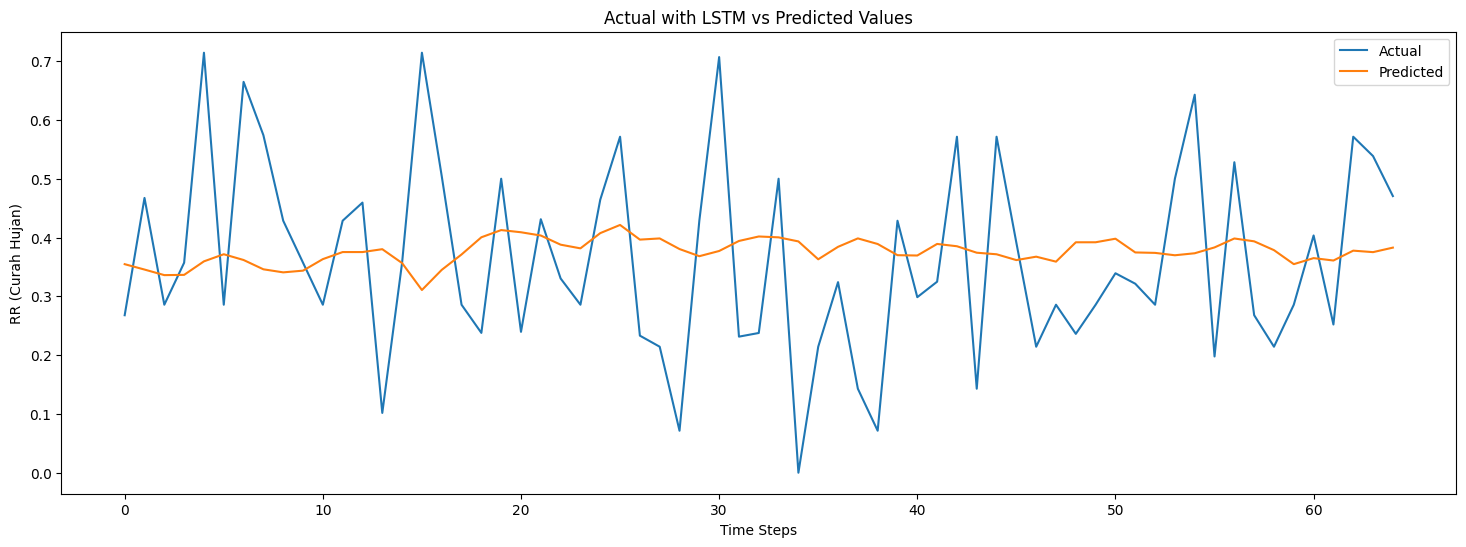

In [29]:
# Plot prediksi vs nilai sebenarnya LSTM Reguler
plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual with LSTM vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

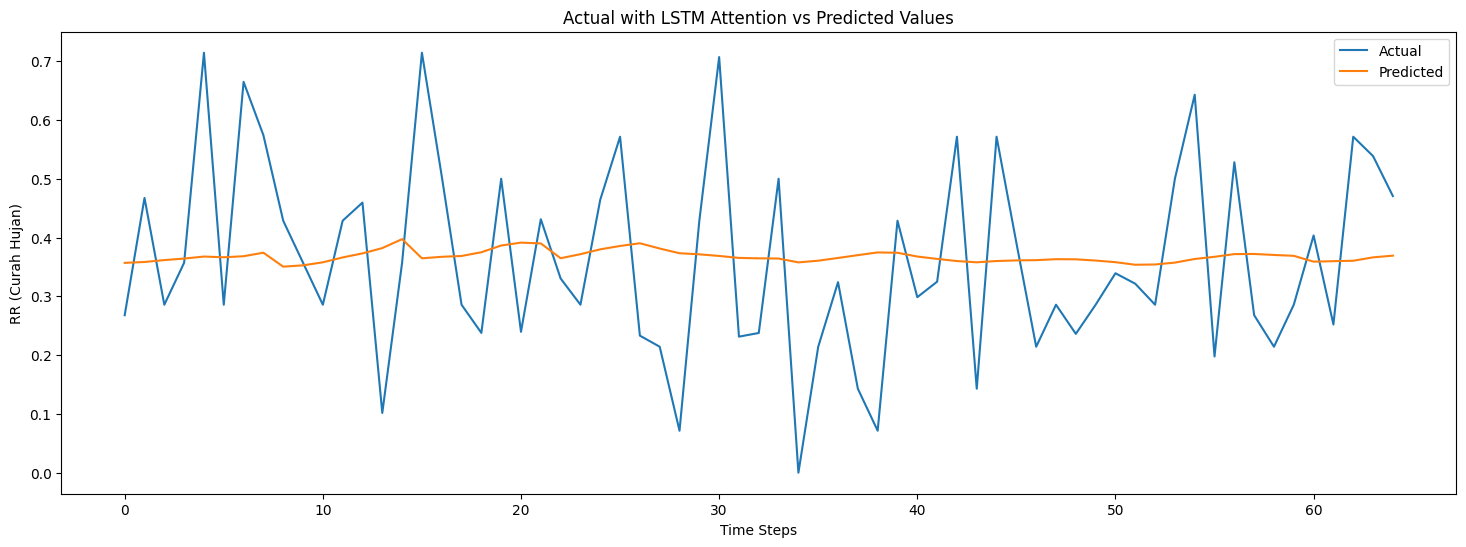

In [31]:
# Plot prediksi vs nilai sebenarnya LSTM Attention

# Mengembalikan ke nilai asli
plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm_attention, label='Predicted')
plt.title('Actual with LSTM Attention vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()